<a href="https://colab.research.google.com/github/RicardoCastelhano/end-to-end-face-recognition-deep-learning/blob/main/Pipeline_facial_detection_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Data-Driven Modular Pipeline for Facial Detection and Character Classification Using Deep Learning

##Sistema de Reconhecimento Facial Modular com TensorFlow
#Introdução

Este projeto tem como objetivo a construção de um sistema de reconhecimento facial do zero, utilizando TensorFlow/Keras no Google Colab, seguindo uma arquitetura modular, reutilizável em projetos futuros.

O sistema é dividido em duas grandes etapas, conforme solicitado no enunciado:

Detecção Facial: localizar automaticamente uma ou mais faces em uma imagem.

Classificação (Reconhecimento): identificar a qual personagem da série The Office cada face pertence.

A proposta foi pensada para refletir um pipeline real de Visão Computacional, separando responsabilidades e facilitando manutenção, evolução e reaproveitamento do código.


####  Visao Geral

Pipeline completo segue o fluxo:

Imagem de entrada → Detector Facial → Recorte das Faces → Pré-processamento → Rede Classificadora → Resultado final

Cada etapa será implementada em blocos independentes, com explicação teórica seguida do código correspondente.

Preparação do Ambiente e Verificação do Dataset

Antes de iniciar a implementação do sistema de detecção e reconhecimento facial, é fundamental garantir que o ambiente de execução e o conjunto de dados estejam corretamente configurados.

Nesta etapa inicial, realizamos uma série de verificações básicas, cujo objetivo é assegurar que:



* O Google Drive foi corretamente montado no ambiente do Google Colab;
* A estrutura de diretórios do dataset foi criada conforme o padrão definido para o projeto;
* O dataset foi corretamente carregado no diretório esperado;
* As pastas de treinamento (train) e validação (val) existem e estão acessíveis;
* Cada personagem da série The Office possui sua própria pasta, representando uma classe distinta para o modelo de classificação.

Dataset baixado: https://www.kaggle.com/datasets/kushagrakinjawadekar/game-of-thrones-character-classification

Essas verificações são essenciais para evitar erros durante as etapas posteriores de carregamento de dados, treinamento da rede neural e avaliação do modelo. Além disso, garantir a correta organização do dataset permite uma integração direta com as ferramentas de geração de dados do TensorFlow, como o ImageDataGenerator.

Somente após confirmar que o ambiente e os dados estão devidamente preparados, o projeto avança para a etapa de importação das bibliotecas, construção dos módulos do sistema e treinamento dos modelos de Deep Learning.

# BLOCO 1: Verificação do Dataset
O que faz:

Monta o Google Drive no ambiente Colab
Detecta automaticamente as classes (personagens) presentes no dataset
Valida a estrutura de pastas (train/val)
Conta quantas imagens existem por classe

Por que é importante:
Antes de treinar qualquer modelo, precisamos garantir que:

O dataset está acessível
As pastas estão organizadas corretamente
Não há classes vazias que causariam erro no treinamento

Conceitos:

Classes: Cada personagem é uma classe (ex: john_snow, daenerys_targaryen)
Train/Val Split: Dividimos os dados em treino (para aprender) e validação (para testar)

In [1]:
# =============================
# BLOCO 1: VERIFICAÇÃO DO DATASET
# =============================
from google.colab import drive
drive.mount('/content/drive')

import os

DATASET_PATH = '/content/drive/MyDrive/datasets/game_of_thrones'

# Detecta automaticamente as classes
train_path = os.path.join(DATASET_PATH, 'train')
if not os.path.exists(train_path):
    raise FileNotFoundError(f'❌ Pasta train não encontrada em: {DATASET_PATH}')

CLASSES = sorted([d for d in os.listdir(train_path)
                  if os.path.isdir(os.path.join(train_path, d))])

print(f'✅ Classes detectadas automaticamente: {CLASSES}')
print(f'📊 Total de classes: {len(CLASSES)}\n')

def check_dataset_structure(base_path, classes):
    print('🔍 Verificando estrutura do dataset...\n')

    if not os.path.exists(base_path):
        print('❌ Pasta principal do dataset NÃO encontrada.')
        return False
    print('✅ Pasta principal encontrada.')

    for split in ['train', 'val']:
        split_path = os.path.join(base_path, split)

        if not os.path.exists(split_path):
            print(f'❌ Pasta "{split}" NÃO encontrada.')
            return False
        print(f'✅ Pasta "{split}" encontrada.')

        for cls in classes:
            class_path = os.path.join(split_path, cls)

            if not os.path.exists(class_path):
                print(f'❌ Classe "{cls}" NÃO encontrada em {split}.')
                return False

            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

            if len(images) == 0:
                print(f'❌ Classe "{cls}" em {split} está VAZIA.')
                return False
            print(f'✅ Classe "{cls}" em {split}: {len(images)} imagens.')

    print('\n🎉 Dataset verificado com sucesso!')
    return True

dataset_ok = check_dataset_structure(DATASET_PATH, CLASSES)
DATASET_BASE = DATASET_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Classes detectadas automaticamente: ['Arya Stark', 'Daenerys Targaryen', 'John Snow', 'Sansa Stark', 'Tyrion Lannister']
📊 Total de classes: 5

🔍 Verificando estrutura do dataset...

✅ Pasta principal encontrada.
✅ Pasta "train" encontrada.
✅ Classe "Arya Stark" em train: 251 imagens.
✅ Classe "Daenerys Targaryen" em train: 151 imagens.
✅ Classe "John Snow" em train: 151 imagens.
✅ Classe "Sansa Stark" em train: 151 imagens.
✅ Classe "Tyrion Lannister" em train: 151 imagens.
✅ Pasta "val" encontrada.
✅ Classe "Arya Stark" em val: 103 imagens.
✅ Classe "Daenerys Targaryen" em val: 38 imagens.
✅ Classe "John Snow" em val: 87 imagens.
✅ Classe "Sansa Stark" em val: 68 imagens.
✅ Classe "Tyrion Lannister" em val: 59 imagens.

🎉 Dataset verificado com sucesso!


# BLOCO 2: Configurações do Projeto
O que faz:
Define todas as configurações globais do projeto em um único lugar.
Parâmetros principais:

MODEL_PATH: Onde o modelo treinado será salvo
IMAGE_SIZE: (224, 224) - tamanho que todas as imagens serão redimensionadas
BATCH_SIZE: 16 - quantas imagens processar por vez
EPOCHS: 100 - máximo de iterações completas pelo dataset

Por que é importante:
Centralizar as configurações facilita ajustes futuros. Se quisermos mudar o tamanho da imagem ou número de épocas, alteramos apenas aqui.
Conceitos:

Batch Size: Processar muitas imagens de uma vez usa mais memória, mas é mais rápido
Epochs: Uma época = passar por todo o dataset uma vez

In [2]:
# =============================
# BLOCO 2: CONFIGURAÇÕES OTIMIZADAS
# =============================

MODEL_PATH = '/content/drive/MyDrive/models/game_of_thrones_optimized.h5'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 100  # Aumentado para melhor convergência

print('\n⚙️ CONFIGURAÇÕES OTIMIZADAS')
print(f'📁 Dataset: {DATASET_BASE}')
print(f'💾 Modelo: {MODEL_PATH}')
print(f'🖼️ Tamanho: {IMAGE_SIZE}')
print(f'📦 Batch: {BATCH_SIZE}')
print(f'🔄 Épocas: {EPOCHS}')
print(f'🎭 Classes: {CLASSES}')


⚙️ CONFIGURAÇÕES OTIMIZADAS
📁 Dataset: /content/drive/MyDrive/datasets/game_of_thrones
💾 Modelo: /content/drive/MyDrive/models/game_of_thrones_optimized.h5
🖼️ Tamanho: (224, 224)
📦 Batch: 16
🔄 Épocas: 100
🎭 Classes: ['Arya Stark', 'Daenerys Targaryen', 'John Snow', 'Sansa Stark', 'Tyrion Lannister']


#BLOCO 3: Importação de Bibliotecas
O que faz:
Importa todas as ferramentas necessárias para o projeto.
Bibliotecas principais:

OpenCV (cv2): Manipulação de imagens
NumPy: Operações matemáticas com arrays
TensorFlow/Keras: Framework de Deep Learning
Matplotlib: Visualização de gráficos

Por que é importante:
É como preparar todos os ingredientes antes de cozinhar. Importar tudo no início evita problemas de dependências depois.

In [3]:
# =============================
# BLOCO 3: IMPORTS
# =============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print(f'\n🔧 TensorFlow: {tf.__version__}')


🔧 TensorFlow: 2.19.0


#BLOCO 4: Detector Multi-Método de Faces
O que faz:
Implementa 4 detectores diferentes para encontrar rostos em imagens:
1️⃣ DNN (Deep Neural Network)

Usa uma rede neural pré-treinada
Mais robusto e preciso
Funciona bem em várias condições de iluminação

2️⃣ MTCNN (Multi-task Cascaded Convolutional Networks)

Especializado em detecção facial
Detecta faces, olhos, nariz e boca
Excelente para faces frontais

3️⃣ Haar Cascade

Método clássico baseado em características
Rápido e leve
Três variações: frontal, frontal alternativo, e perfil

4️⃣ Modo 'all'

Combina todos os métodos
Remove detecções duplicadas usando IoU (Intersection over Union)

Estratégia (modo 'auto'):
Tenta na ordem: DNN → MTCNN → Haar até encontrar faces.
Por que é importante:
Diferentes métodos têm pontos fortes diferentes. Combinar vários aumenta drasticamente a taxa de detecção.
Conceitos:

Bounding Box: Retângulo (x, y, largura, altura) que delimita a face
IoU: Métrica para medir sobreposição entre caixas (usado para eliminar duplicatas)

In [4]:
# =============================
# BLOCO 4: DETECTOR MULTI-MÉTODO (OTIMIZADO)
# =============================

print('\n🔍 CONFIGURANDO DETECTORES DE FACES')
print('=' * 60)

# 1. MTCNN
try:
    !pip install lz4 mtcnn --quiet
    import sys
    if 'mtcnn' in sys.modules:
        del sys.modules['mtcnn']
    from mtcnn import MTCNN
    detector_mtcnn = MTCNN()
    USE_MTCNN = True
    print('✅ MTCNN carregado')
except:
    USE_MTCNN = False
    print('❌ MTCNN indisponível')

# 2. Haar Cascades
haar_face = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
haar_face_alt = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
haar_profile = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')
print('✅ Haar Cascades carregados')

# 3. DNN
try:
    import urllib.request
    modelFile = "opencv_face_detector_uint8.pb"
    configFile = "opencv_face_detector.pbtxt"

    if not os.path.exists(modelFile):
        print('📥 Baixando modelo DNN...')
        urllib.request.urlretrieve(
            "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/opencv_face_detector_uint8.pb",
            modelFile
        )

    if not os.path.exists(configFile):
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/opencv_face_detector.pbtxt",
            configFile
        )

    detector_dnn = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
    USE_DNN = True
    print('✅ DNN carregado')
except:
    USE_DNN = False
    print('⚠️ DNN indisponível')

print('=' * 60)

def _detect_dnn(image, min_confidence=0.5):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    detector_dnn.setInput(blob)
    detections = detector_dnn.forward()

    boxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > min_confidence:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype("int")
            x, y = max(0, x1), max(0, y1)
            box_w, box_h = x2 - x1, y2 - y1
            if box_w > 0 and box_h > 0:
                boxes.append((x, y, box_w, box_h))
    return boxes

def _detect_mtcnn(image, min_confidence=0.85):
    detections = detector_mtcnn.detect_faces(image)
    boxes = []
    for det in detections:
        if det['confidence'] >= min_confidence:
            x, y, w, h = det['box']
            boxes.append((max(0, x), max(0, y), w, h))
    return boxes

def _detect_haar(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    boxes = []

    # Frontal default
    faces1 = haar_face.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    boxes.extend([(x, y, w, h) for x, y, w, h in faces1])

    # Frontal alternativo
    faces2 = haar_face_alt.detectMultiScale(gray, 1.05, 3, minSize=(30, 30))
    boxes.extend([(x, y, w, h) for x, y, w, h in faces2])

    # Profile
    profiles = haar_profile.detectMultiScale(gray, 1.1, 5, minSize=(30, 30))
    boxes.extend([(x, y, w, h) for x, y, w, h in profiles])

    return boxes

def _remove_duplicates(boxes, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes_array = np.array(boxes)
    x, y, w, h = boxes_array[:, 0], boxes_array[:, 1], boxes_array[:, 2], boxes_array[:, 3]
    areas = w * h
    order = areas.argsort()[::-1]

    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x[i], x[order[1:]])
        yy1 = np.maximum(y[i], y[order[1:]])
        xx2 = np.minimum(x[i] + w[i], x[order[1:]] + w[order[1:]])
        yy2 = np.minimum(y[i] + h[i], y[order[1:]] + h[order[1:]])

        w_inter = np.maximum(0, xx2 - xx1)
        h_inter = np.maximum(0, yy2 - yy1)
        inter = w_inter * h_inter
        union = areas[i] + areas[order[1:]] - inter
        iou = inter / union

        inds = np.where(iou <= threshold)[0]
        order = order[inds + 1]

    return [boxes[i] for i in keep]

def detect_faces(image, method='auto', min_confidence=0.5):
    if method == 'auto':
        # Tenta DNN primeiro
        if USE_DNN:
            boxes = _detect_dnn(image, min_confidence)
            if boxes:
                return boxes

        # Depois MTCNN
        if USE_MTCNN:
            boxes = _detect_mtcnn(image, min_confidence)
            if boxes:
                return boxes

        # Fallback: Haar
        return _remove_duplicates(_detect_haar(image))

    elif method == 'all':
        all_boxes = []
        if USE_DNN:
            all_boxes.extend(_detect_dnn(image, min_confidence))
        if USE_MTCNN:
            all_boxes.extend(_detect_mtcnn(image, min_confidence))
        all_boxes.extend(_detect_haar(image))
        return _remove_duplicates(all_boxes)

    elif method == 'dnn' and USE_DNN:
        return _detect_dnn(image, min_confidence)

    elif method == 'mtcnn' and USE_MTCNN:
        return _detect_mtcnn(image, min_confidence)

    elif method == 'haar':
        return _remove_duplicates(_detect_haar(image))

    return []

print('✅ Detector multi-método carregado')


🔍 CONFIGURANDO DETECTORES DE FACES
✅ MTCNN carregado
✅ Haar Cascades carregados
📥 Baixando modelo DNN...
⚠️ DNN indisponível
✅ Detector multi-método carregado


#BLOCO 5: Pré-processamento de Faces
O que faz:
Após detectar uma face, este bloco:

Recorta a região da face da imagem original
Redimensiona para 224×224 pixels
Normaliza os valores dos pixels para o intervalo [0, 1]

Por que é importante:
Redes neurais esperam entradas padronizadas. Todas as faces devem ter o mesmo tamanho e escala de valores.
Conceitos:

Normalização: Dividir por 255 transforma pixels de [0-255] para [0-1]
Resize: Garante que todas as entradas tenham dimensões consistentes

In [5]:
# =============================
# BLOCO 5: PRÉ-PROCESSAMENTO
# =============================

def preprocess_face(image, box, target_size=IMAGE_SIZE):
    x, y, w, h = box
    height, width = image.shape[:2]

    x = max(0, x)
    y = max(0, y)
    w = min(w, width - x)
    h = min(h, height - y)

    face = image[y:y+h, x:x+w]

    if face.size == 0 or face.shape[0] == 0 or face.shape[1] == 0:
        return None

    face = cv2.resize(face, target_size)
    face = face / 255.0

    return face

print('✅ Pré-processamento carregado')

✅ Pré-processamento carregado


#📚 Documentação Didática - Pipeline de Reconhecimento Facial Game of Thrones
🎯 Visão Geral do Projeto
Este projeto implementa um sistema completo de reconhecimento facial para identificar personagens da série Game of Thrones. O pipeline é dividido em 13 blocos modulares que seguem o fluxo:
Dataset → Detecção Facial → Classificação → Resultado

📦 BLOCO 1: Verificação do Dataset
O que faz:

Monta o Google Drive no ambiente Colab
Detecta automaticamente as classes (personagens) presentes no dataset
Valida a estrutura de pastas (train/val)
Conta quantas imagens existem por classe

Por que é importante:
Antes de treinar qualquer modelo, precisamos garantir que:

O dataset está acessível
As pastas estão organizadas corretamente
Não há classes vazias que causariam erro no treinamento

Conceitos:

Classes: Cada personagem é uma classe (ex: john_snow, daenerys_targaryen)
Train/Val Split: Dividimos os dados em treino (para aprender) e validação (para testar)


⚙️ BLOCO 2: Configurações do Projeto
O que faz:
Define todas as configurações globais do projeto em um único lugar.
Parâmetros principais:

MODEL_PATH: Onde o modelo treinado será salvo
IMAGE_SIZE: (224, 224) - tamanho que todas as imagens serão redimensionadas
BATCH_SIZE: 16 - quantas imagens processar por vez
EPOCHS: 100 - máximo de iterações completas pelo dataset

Por que é importante:
Centralizar as configurações facilita ajustes futuros. Se quisermos mudar o tamanho da imagem ou número de épocas, alteramos apenas aqui.
Conceitos:

Batch Size: Processar muitas imagens de uma vez usa mais memória, mas é mais rápido
Epochs: Uma época = passar por todo o dataset uma vez


📚 BLOCO 3: Importação de Bibliotecas
O que faz:
Importa todas as ferramentas necessárias para o projeto.
Bibliotecas principais:

OpenCV (cv2): Manipulação de imagens
NumPy: Operações matemáticas com arrays
TensorFlow/Keras: Framework de Deep Learning
Matplotlib: Visualização de gráficos

Por que é importante:
É como preparar todos os ingredientes antes de cozinhar. Importar tudo no início evita problemas de dependências depois.

🔍 BLOCO 4: Detector Multi-Método de Faces
O que faz:
Implementa 4 detectores diferentes para encontrar rostos em imagens:
1️⃣ DNN (Deep Neural Network)

Usa uma rede neural pré-treinada
Mais robusto e preciso
Funciona bem em várias condições de iluminação

2️⃣ MTCNN (Multi-task Cascaded Convolutional Networks)

Especializado em detecção facial
Detecta faces, olhos, nariz e boca
Excelente para faces frontais

3️⃣ Haar Cascade

Método clássico baseado em características
Rápido e leve
Três variações: frontal, frontal alternativo, e perfil

4️⃣ Modo 'all'

Combina todos os métodos
Remove detecções duplicadas usando IoU (Intersection over Union)

Estratégia (modo 'auto'):
Tenta na ordem: DNN → MTCNN → Haar até encontrar faces.
Por que é importante:
Diferentes métodos têm pontos fortes diferentes. Combinar vários aumenta drasticamente a taxa de detecção.
Conceitos:

Bounding Box: Retângulo (x, y, largura, altura) que delimita a face
IoU: Métrica para medir sobreposição entre caixas (usado para eliminar duplicatas)


🖼️ BLOCO 5: Pré-processamento de Faces
O que faz:
Após detectar uma face, este bloco:

Recorta a região da face da imagem original
Redimensiona para 224×224 pixels
Normaliza os valores dos pixels para o intervalo [0, 1]

Por que é importante:
Redes neurais esperam entradas padronizadas. Todas as faces devem ter o mesmo tamanho e escala de valores.
Conceitos:

Normalização: Dividir por 255 transforma pixels de [0-255] para [0-1]
Resize: Garante que todas as entradas tenham dimensões consistentes


🧠 BLOCO 6: Construção do Modelo Classificador
O que faz:
Cria a arquitetura da rede neural que aprenderá a identificar os personagens.
Arquitetura:
MobileNetV2 (base pré-treinada)
    ↓
GlobalAveragePooling2D
    ↓
Dense(512) + BatchNorm + Dropout(0.5)
    ↓
Dense(256) + BatchNorm + Dropout(0.4)
    ↓
Dense(128) + Dropout(0.3)
    ↓
Dense(num_classes, softmax)
Componentes:
MobileNetV2 (Transfer Learning)

Rede pré-treinada no ImageNet (1.4M imagens)
Já aprendeu características visuais gerais
Fine-tuning: últimas 80 camadas são retreinadas para nosso problema específico

Dense Layers

Camadas totalmente conectadas que aprendem a classificar
512 → 256 → 128: redução progressiva de dimensionalidade

BatchNormalization

Normaliza ativações entre camadas
Acelera treinamento e melhora estabilidade

Dropout

"Desliga" neurônios aleatoriamente durante treino
Previne overfitting (decorar ao invés de aprender)
Valores progressivos: 0.5 → 0.4 → 0.3

Regularização L2

Penaliza pesos muito grandes
Também previne overfitting

Softmax

Converte saídas em probabilidades que somam 1
Ex: [0.85, 0.10, 0.03, 0.02] = 85% Tyrion, 10% Daenerys...

Por que é importante:
É o "cérebro" do sistema. A arquitetura determina o que o modelo consegue aprender.
Conceitos:

Transfer Learning: Reutilizar conhecimento de uma tarefa para outra
Fine-tuning: Ajustar camadas finais para tarefa específica
Overfitting: Modelo decora dados de treino mas falha em dados novos

In [6]:
# =============================
# BLOCO 6: MODELO OTIMIZADO
# =============================

def build_classifier(num_classes):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Fine-tuning: 80 camadas
    base_model.trainable = True
    for layer in base_model.layers[:-80]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print(f'\n🏗️ Construindo modelo para {len(CLASSES)} classes')
print('⚡ Config: 80 camadas + L2 + BatchNorm + 512→256→128')
model = build_classifier(num_classes=len(CLASSES))


🏗️ Construindo modelo para 5 classes
⚡ Config: 80 camadas + L2 + BatchNorm + 512→256→128


#BLOCO 7: Data Augmentation (Aumento de Dados)
O que faz:
Cria variações artificiais das imagens de treino aplicando transformações aleatórias.
Transformações aplicadas:

Rotação: ±20° (simula cabeça inclinada)
Shifts: ±15% horizontal/vertical (simula face descentrada)
Zoom: ±20% (simula diferentes distâncias)
Shear: 0.1 (leve distorção angular)
Flip horizontal: Espelha a imagem
Brightness: 80%-120% (simula diferentes iluminações)
Channel shift: ±20 (varia cores RGB)

Por que é importante:
Com apenas ~150 imagens por classe, o modelo poderia facilmente decorar. Data augmentation:

Aumenta virtualmente o tamanho do dataset
Torna o modelo mais robusto a variações
Melhora a generalização

Conceitos:

Generalização: Capacidade de funcionar bem em dados nunca vistos
Augmentation: Criar variações sem coletar mais dados reais

In [7]:
# =============================
# BLOCO 7: DATA AUGMENTATION
# =============================

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

print('\n✅ Data augmentation configurado')


✅ Data augmentation configurado


#BLOCO 8: Generators (Geradores de Dados)
O que faz:
Cria geradores que alimentam o modelo com batches de imagens durante o treino.
Dois generators:
train_generator

Aplica data augmentation
Embaralha dados a cada época
Usado para treinar o modelo

val_generator

SEM augmentation (queremos avaliar em dados "puros")
Não embaralha (consistência nas métricas)
Usado para validar o modelo

Por que é importante:
Carregar todas as imagens na memória seria impossível. Generators carregam dados sob demanda (lazy loading), economizando RAM.
Conceitos:

flow_from_directory: Lê imagens diretamente das pastas
class_mode='categorical': Cada classe vira um vetor one-hot
shuffle: Embaralhar previne que o modelo aprenda a ordem dos dados

In [8]:
# =============================
# BLOCO 8: GENERATORS
# =============================

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_BASE, 'train'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATASET_BASE, 'val'),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = list(train_generator.class_indices.keys())

print(f'\n✅ Generators criados')
print(f'📊 Treino: {train_generator.samples} | Val: {val_generator.samples}')
print(f'🎭 Classes: {class_names}')

Found 855 images belonging to 5 classes.
Found 355 images belonging to 5 classes.

✅ Generators criados
📊 Treino: 855 | Val: 355
🎭 Classes: ['Arya Stark', 'Daenerys Targaryen', 'John Snow', 'Sansa Stark', 'Tyrion Lannister']


#BLOCO 9: Treinamento do Modelo
O que faz:
Treina a rede neural usando os dados preparados.
Callbacks (funções automáticas):
ModelCheckpoint

Salva o melhor modelo automaticamente
Monitora val_accuracy (acurácia de validação)
Só salva se melhorar

EarlyStopping

Para o treino se não houver melhoria
Patience=25: aguarda 25 épocas antes de desistir
Restaura os melhores pesos

ReduceLROnPlateau

Reduz learning rate se estagnar
Patience=8: aguarda 8 épocas
Factor=0.5: reduz LR pela metade

Processo de treinamento:
Para cada época:
    1. Passa por todos os batches de treino
    2. Calcula erro (loss)
    3. Ajusta pesos via backpropagation
    4. Valida no conjunto de validação
    5. Callbacks decidem: salvar? parar? reduzir LR?
Por que é importante:
É aqui que o aprendizado acontece. O modelo ajusta milhões de parâmetros para minimizar o erro.
Conceitos:

Learning Rate: Tamanho do "passo" ao ajustar pesos
Loss: Medida de erro (quanto menor, melhor)
Backpropagation: Algoritmo que calcula como ajustar cada peso
Validation: Testar em dados não vistos no treino

In [9]:
# =============================
# BLOCO 9: TREINAMENTO OTIMIZADO
# =============================

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

callbacks = [
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1)
]

print(f'\n🚀 Iniciando treinamento otimizado')
print(f'⏱️ Épocas: {EPOCHS} | Patience: 25\n')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print('\n✅ Treinamento concluído!')


🚀 Iniciando treinamento otimizado
⏱️ Épocas: 100 | Patience: 25



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2240 - loss: 13.1401
Epoch 1: val_accuracy improved from -inf to 0.17746, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.2237 - loss: 13.1403 - val_accuracy: 0.1775 - val_loss: 12.4342 - learning_rate: 5.0000e-05
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2177 - loss: 12.8727
Epoch 2: val_accuracy improved from 0.17746 to 0.26479, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2183 - loss: 12.8719 - val_accuracy: 0.2648 - val_loss: 12.2594 - learning_rate: 5.0000e-05
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3011 - loss: 12.6332
Epoch 3: val_accuracy improved from 0.26479 to 0.36338, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3010 - loss: 12.6335 - val_accuracy: 0.3634 - val_loss: 12.0868 - learning_rate: 5.0000e-05
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3201 - loss: 12.4767
Epoch 4: val_accuracy improved from 0.36338 to 0.44507, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3201 - loss: 12.4757 - val_accuracy: 0.4451 - val_loss: 11.9077 - learning_rate: 5.0000e-05
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3881 - loss: 12.2528
Epoch 5: val_accuracy improved from 0.44507 to 0.50704, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3882 - loss: 12.2521 - val_accuracy: 0.5070 - val_loss: 11.7558 - learning_rate: 5.0000e-05
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4165 - loss: 12.0635
Epoch 6: val_accuracy improved from 0.50704 to 0.52676, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4167 - loss: 12.0634 - val_accuracy: 0.5268 - val_loss: 11.6475 - learning_rate: 5.0000e-05
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4518 - loss: 12.0072
Epoch 7: val_accuracy improved from 0.52676 to 0.55775, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4518 - loss: 12.0069 - val_accuracy: 0.5577 - val_loss: 11.5352 - learning_rate: 5.0000e-05
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4653 - loss: 11.8794
Epoch 8: val_accuracy improved from 0.55775 to 0.60563, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4658 - loss: 11.8782 - val_accuracy: 0.6056 - val_loss: 11.4142 - learning_rate: 5.0000e-05
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5379 - loss: 11.6310
Epoch 9: val_accuracy improved from 0.60563 to 0.63662, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5377 - loss: 11.6319 - val_accuracy: 0.6366 - val_loss: 11.2951 - learning_rate: 5.0000e-05
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5396 - loss: 11.5120
Epoch 10: val_accuracy improved from 0.63662 to 0.64789, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5392 - loss: 11.5136 - val_accuracy: 0.6479 - val_loss: 11.2118 - learning_rate: 5.0000e-05
Epoch 11/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5890 - loss: 11.4395
Epoch 11: val_accuracy improved from 0.64789 to 0.67887, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.5892 - loss: 11.4392 - val_accuracy: 0.6789 - val_loss: 11.1105 - learning_rate: 5.0000e-05
Epoch 12/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6038 - loss: 11.3243
Epoch 12: val_accuracy improved from 0.67887 to 0.68169, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6042 - loss: 11.3234 - val_accuracy: 0.6817 - val_loss: 11.0555 - learning_rate: 5.0000e-05
Epoch 13/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5988 - loss: 11.3020
Epoch 13: val_accuracy improved from 0.68169 to 0.71549, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5991 - loss: 11.3011 - val_accuracy: 0.7155 - val_loss: 10.9788 - learning_rate: 5.0000e-05
Epoch 14/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6520 - loss: 11.1802
Epoch 14: val_accuracy did not improve from 0.71549
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6518 - loss: 11.1795 - val_accuracy: 0.7042 - val_loss: 10.9265 - learning_rate: 5.0000e-05
Epoch 15/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6608 - loss: 11.0391
Epoch 15: val_accuracy improved from 0.71549 to 0.72113, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6606 - loss: 11.0392 - val_accuracy: 0.7211 - val_loss: 10.8339 - learning_rate: 5.0000e-05
Epoch 16/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6849 - loss: 10.9454
Epoch 16: val_accuracy improved from 0.72113 to 0.75775, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6848 - loss: 10.9454 - val_accuracy: 0.7577 - val_loss: 10.7334 - learning_rate: 5.0000e-05
Epoch 17/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6622 - loss: 10.9352
Epoch 17: val_accuracy improved from 0.75775 to 0.76901, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6625 - loss: 10.9343 - val_accuracy: 0.7690 - val_loss: 10.6761 - learning_rate: 5.0000e-05
Epoch 18/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7053 - loss: 10.8223
Epoch 18: val_accuracy did not improve from 0.76901
54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7052 - loss: 10.8218 - val_accuracy: 0.7690 - val_loss: 10.6154 - learning_rate: 5.0000e-05
Epoch 19/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7140 - loss: 10.7314
Epoch 19: val_accuracy improved from 0.76901 to 0.77465, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7141 - loss: 10.7308 - val_accuracy: 0.7746 - val_loss: 10.5541 - learning_rate: 5.0000e-05
Epoch 20/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7319 - loss: 10.6514
Epoch 20: val_accuracy improved from 0.77465 to 0.80000, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7320 - loss: 10.6507 - val_accuracy: 0.8000 - val_loss: 10.4863 - learning_rate: 5.0000e-05
Epoch 21/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7553 - loss: 10.5228
Epoch 21: val_accuracy did not improve from 0.80000
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7554 - loss: 10.5228 - val_accuracy: 0.7972 - val_loss: 10.4294 - learning_rate: 5.0000e-05
Epoch 22/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7513 - loss: 10.5274
Epoch 22: val_accuracy improved from 0.80000 to 0.81972, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7514 - loss: 10.5266 - val_accuracy: 0.8197 - val_loss: 10.3648 - learning_rate: 5.0000e-05
Epoch 23/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7718 - loss: 10.3714
Epoch 23: val_accuracy improved from 0.81972 to 0.82535, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7719 - loss: 10.3712 - val_accuracy: 0.8254 - val_loss: 10.2912 - learning_rate: 5.0000e-05
Epoch 24/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7708 - loss: 10.3347
Epoch 24: val_accuracy did not improve from 0.82535
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7710 - loss: 10.3344 - val_accuracy: 0.8254 - val_loss: 10.2230 - learning_rate: 5.0000e-05
Epoch 25/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7741 - loss: 10.2633
Epoch 25: val_accuracy did not improve from 0.82535
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7748 - loss: 10.2619 - val_accuracy: 0.8141 - val_loss: 10.1469 - learning_rate: 5.0000e-05
Epoch 26/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7987 - loss: 10.1389
Epoch 26: val_accuracy did not improve from 0.82535
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7990 - loss: 10.1385 - val_accuracy: 0.8254 - val_loss: 10.0741 - learning_rate: 5.0000e-05
Ep

54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8120 - loss: 10.0640 - val_accuracy: 0.8394 - val_loss: 10.0114 - learning_rate: 5.0000e-05
Epoch 28/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8240 - loss: 9.9662
Epoch 28: val_accuracy did not improve from 0.83944
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8241 - loss: 9.9658 - val_accuracy: 0.8310 - val_loss: 9.9378 - learning_rate: 5.0000e-05
Epoch 29/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8323 - loss: 9.9062
Epoch 29: val_accuracy improved from 0.83944 to 0.84507, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8323 - loss: 9.9058 - val_accuracy: 0.8451 - val_loss: 9.8694 - learning_rate: 5.0000e-05
Epoch 30/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8069 - loss: 9.9270
Epoch 30: val_accuracy improved from 0.84507 to 0.85634, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8072 - loss: 9.9256 - val_accuracy: 0.8563 - val_loss: 9.8045 - learning_rate: 5.0000e-05
Epoch 31/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8086 - loss: 9.7759
Epoch 31: val_accuracy did not improve from 0.85634
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8089 - loss: 9.7763 - val_accuracy: 0.8507 - val_loss: 9.7253 - learning_rate: 5.0000e-05
Epoch 32/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8258 - loss: 9.7512
Epoch 32: val_accuracy did not improve from 0.85634
54/54 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8257 - loss: 9.7506 - val_accuracy: 0.8451 - val_loss: 9.6731 - learning_rate: 5.0000e-05
Epoch 33/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8861 - loss: 9.5382
Epoch 33: val_accuracy improved from 0.85634 to 0.86479, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8856 - loss: 9.5391 - val_accuracy: 0.8648 - val_loss: 9.5968 - learning_rate: 5.0000e-05
Epoch 34/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8750 - loss: 9.4546
Epoch 34: val_accuracy did not improve from 0.86479
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8749 - loss: 9.4549 - val_accuracy: 0.8592 - val_loss: 9.5377 - learning_rate: 5.0000e-05
Epoch 35/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8660 - loss: 9.4533
Epoch 35: val_accuracy did not improve from 0.86479
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8660 - loss: 9.4533 - val_accuracy: 0.8507 - val_loss: 9.4824 - learning_rate: 5.0000e-05
Epoch 36/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8822 - loss: 9.3696
Epoch 36: val_accuracy did not improve from 0.86479
54/54 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8823 - loss: 9.3691 - val_accuracy: 0.8535 - val_loss: 9.4227 - learning_rate: 5.0000e-05
Epoch 37/100


54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8834 - loss: 9.0579 - val_accuracy: 0.8704 - val_loss: 9.1062 - learning_rate: 5.0000e-05
Epoch 42/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8770 - loss: 8.9941
Epoch 42: val_accuracy did not improve from 0.87042
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8772 - loss: 8.9939 - val_accuracy: 0.8676 - val_loss: 9.0438 - learning_rate: 5.0000e-05
Epoch 43/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8980 - loss: 8.9169
Epoch 43: val_accuracy did not improve from 0.87042
54/54 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8979 - loss: 8.9165 - val_accuracy: 0.8676 - val_loss: 8.9540 - learning_rate: 5.0000e-05
Epoch 44/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8828 - loss: 8.8927
Epoch 44: val_accuracy did not improve from 0.87042
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8828 - loss: 8.8925 - val_accuracy: 0.8648 - val_loss: 8.9202 - learning_rate: 5.0000e-05
Epoch 45/100


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9318 - loss: 8.3030 - val_accuracy: 0.8789 - val_loss: 8.4284 - learning_rate: 5.0000e-05
Epoch 52/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9366 - loss: 8.2389
Epoch 52: val_accuracy improved from 0.87887 to 0.89859, saving model to /content/drive/MyDrive/models/game_of_thrones_optimized.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9366 - loss: 8.2385 - val_accuracy: 0.8986 - val_loss: 8.3386 - learning_rate: 5.0000e-05
Epoch 53/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9571 - loss: 8.0968
Epoch 53: val_accuracy did not improve from 0.89859
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9569 - loss: 8.0967 - val_accuracy: 0.8845 - val_loss: 8.3022 - learning_rate: 5.0000e-05
Epoch 54/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9266 - loss: 8.0630
Epoch 54: val_accuracy did not improve from 0.89859
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9267 - loss: 8.0626 - val_accuracy: 0.8930 - val_loss: 8.2108 - learning_rate: 5.0000e-05
Epoch 55/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9516 - loss: 8.0177
Epoch 55: val_accuracy did not improve from 0.89859
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.9514 - loss: 8.0176 - val_accuracy: 0.8789 - val_loss: 8.1592 - learning_rate: 5.0000e-05
Epoch 56/100


#BLOCO 10: Visualização do Treinamento
O que faz:
Plota gráficos de acurácia e loss ao longo das épocas.
Gráficos:

Acurácia: Treino vs Validação
Loss: Treino vs Validação

O que analisar:
✅ Modelo bom:

Treino e validação próximos
Ambos melhoram juntos
Gap < 5%

⚠️ Overfitting:

Treino muito melhor que validação
Gap > 15%
Validação estagna ou piora

⚠️ Underfitting:

Ambos ruins
Não está aprendendo o suficiente

Por que é importante:
Visualizar o treino revela problemas. Se há overfitting, precisamos mais dados ou regularização.
Conceitos:

Overfitting: Decorar ao invés de aprender
Underfitting: Modelo muito simples ou treino insuficiente
Gap: Diferença entre treino e validação


📊 Melhor época: 52
  Acc treino: 0.9357
  Acc val: 0.8986


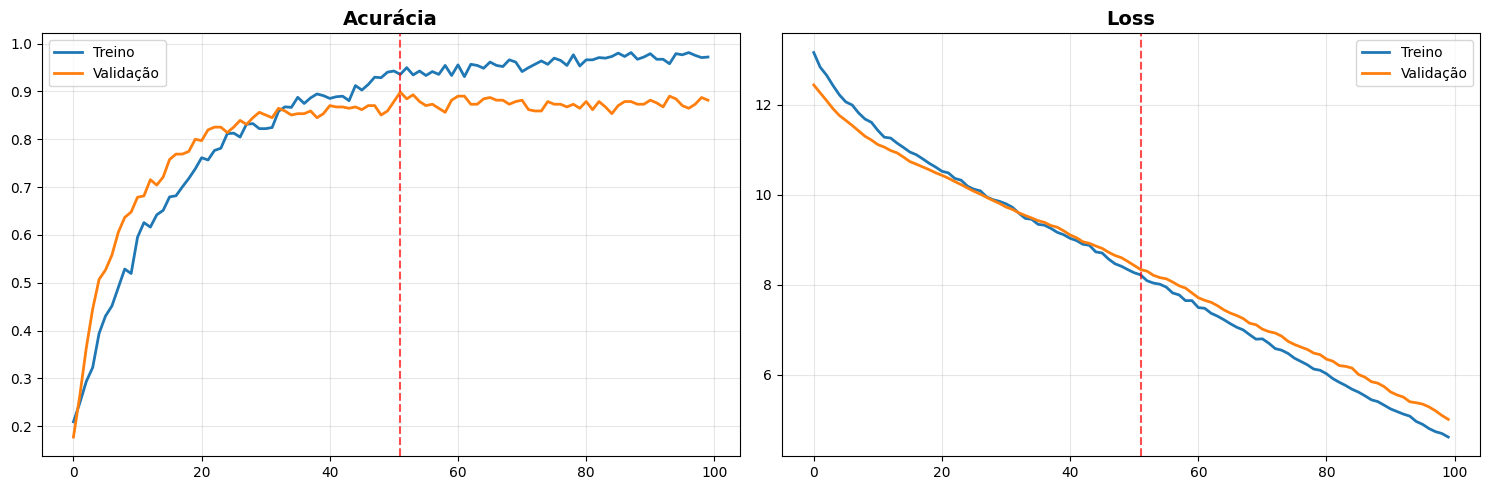

In [10]:
# =============================
# BLOCO 10: VISUALIZAÇÃO
# =============================

best_epoch = np.argmax(history.history['val_accuracy'])
print(f'\n📊 Melhor época: {best_epoch + 1}')
print(f'  Acc treino: {history.history["accuracy"][best_epoch]:.4f}')
print(f'  Acc val: {history.history["val_accuracy"][best_epoch]:.4f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['accuracy'], label='Treino', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validação', linewidth=2)
ax1.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
ax1.set_title('Acurácia', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Treino', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validação', linewidth=2)
ax2.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#BLOCO 11: Pipeline de Reconhecimento
O que faz:
Integra detecção + classificação em uma única função.
Fluxo:
Imagem → Detecta faces → Para cada face:
                            1. Recorta
                            2. Pré-processa
                            3. Classifica
                            4. Filtra por confiança
         → Lista de resultados
Parâmetros:

min_confidence: Threshold mínimo (padrão 0.6 = 60%)
method: Qual detector usar ('auto', 'dnn', 'mtcnn', 'haar', 'all')

Retorna:
Lista de tuplas: (bounding_box, nome, confiança, probabilidades_todas)
Por que é importante:
Abstrai toda a complexidade. Basta passar uma imagem e receber os resultados.
Conceitos:

Confidence: Quão certo o modelo está (0-1)
Threshold: Valor mínimo para aceitar uma predição

In [11]:
# =============================
# BLOCO 11: PIPELINE DE RECONHECIMENTO
# =============================

def recognize_faces(image, model, class_names, min_confidence=0.6, method='auto'):
    boxes = detect_faces(image, method=method)
    results = []

    for box in boxes:
        face = preprocess_face(image, box)
        if face is None:
            continue

        face = np.expand_dims(face, axis=0)
        preds = model.predict(face, verbose=0)
        class_id = np.argmax(preds)
        confidence = preds[0][class_id]

        if confidence >= min_confidence:
            results.append((box, class_names[class_id], confidence, preds[0]))

    return results

print('✅ Pipeline de reconhecimento carregado')

✅ Pipeline de reconhecimento carregado


#BLOCO 12: Visualização dos Resultados
O que faz:
Desenha bounding boxes e labels nas faces detectadas.
Elementos visuais:

Caixa verde: Delimita a face
Label principal: Nome + confiança (fundo verde, texto preto)
Segunda opção (se > 15%): Em amarelo abaixo da caixa

Por que é importante:
Feedback visual é essencial. Permite avaliar rapidamente se o modelo está funcionando.
Conceitos:

Bounding Box: Retângulo que delimita um objeto
Top-N: N predições mais prováveis

In [12]:
# =============================
# BLOCO 12: VISUALIZAÇÃO
# =============================

def draw_results(image, results):
    img = image.copy()

    for result in results:
        if len(result) == 4:
            (x, y, w, h), name, confidence, all_preds = result
        else:
            (x, y, w, h), name, confidence = result
            all_preds = None

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

        label = f"{name}: {confidence:.1%}"
        text_y = max(y - 10, 20)

        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        cv2.rectangle(img, (x, text_y - text_h - 5), (x + text_w + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img, label, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

        if all_preds is not None:
            top2_idx = np.argsort(all_preds)[-2:][::-1]
            second_conf = all_preds[top2_idx[1]]

            if second_conf > 0.15:
                second_label = f"2º: {class_names[top2_idx[1]]} ({second_conf:.1%})"
                cv2.putText(img, second_label, (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

    return img

print('✅ Visualização carregada')

✅ Visualização carregada


BLOCO 13: Inferência Inteligente
O que faz:
Testa o modelo treinado em imagens reais com estratégia adaptativa.
Estratégia de detecção:
1. Tenta método 'auto' (confidence=0.5)
   ↓
   Se não encontrar faces:
   ↓
2. Tenta método 'all' (confidence=0.4)
   ↓
   Se ainda não encontrar:
   ↓
3. Reporta que nenhuma face foi detectada
Saída:

Lista de faces detectadas
Top-3 predições com probabilidades
Imagem anotada com bounding boxes

Por que é importante:
Em produção, nem sempre sabemos o que vem pela frente. A estratégia adaptativa maximiza as chances de sucesso.
Conceitos:

Inferência: Usar modelo treinado para fazer predições
Fallback: Plano B quando o plano A falha
Top-K: K predições mais prováveis


🎯 INICIANDO INFERÊNCIA


✅ Modelo carregado

🖼️  IMAGEM 1/1: got_test3.jpg
✅ Carregada: (482, 712, 3)
🔍 Detectando (auto)...
✅ 2 face(s):

  Face 1: John Snow (82.5%)
    1. John Snow: 82.5%
    2. Sansa Stark: 11.3%
    3. Arya Stark: 4.8%

  Face 2: Daenerys Targaryen (83.5%)
    1. Daenerys Targaryen: 83.5%
    2. Sansa Stark: 11.5%
    3. John Snow: 3.0%



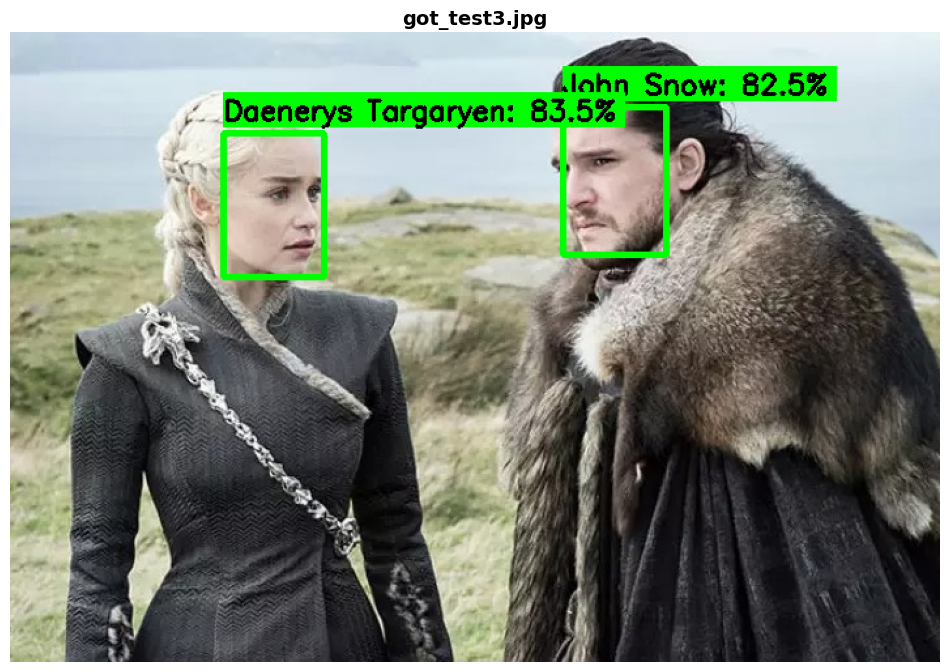

✅ INFERÊNCIA CONCLUÍDA!


In [15]:
# =============================
# BLOCO 13: INFERÊNCIA COM MULTI-DETECTOR
# =============================

TEST_IMAGE_PATHS = [
    '/content/drive/MyDrive/test_images/got_test3.jpg'
]

print('\n🎯 INICIANDO INFERÊNCIA')
print('=' * 60)

from tensorflow.keras.models import load_model
model_loaded = load_model(MODEL_PATH)
print('✅ Modelo carregado\n')

for img_idx, IMAGE_PATH in enumerate(TEST_IMAGE_PATHS, 1):
    print(f'🖼️  IMAGEM {img_idx}/{len(TEST_IMAGE_PATHS)}: {os.path.basename(IMAGE_PATH)}')
    print('=' * 60)

    image_bgr = cv2.imread(IMAGE_PATH)
    if image_bgr is None:
        print(f'❌ Não encontrada: {IMAGE_PATH}\n')
        continue

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    print(f'✅ Carregada: {image_rgb.shape}')

    # Tenta método auto primeiro
    print('🔍 Detectando (auto)...')
    results = recognize_faces(image_rgb, model_loaded, class_names, min_confidence=0.5, method='auto')

    # Se não encontrou, tenta 'all'
    if not results:
        print('⚠️ Tentando todos os métodos...')
        results = recognize_faces(image_rgb, model_loaded, class_names, min_confidence=0.4, method='all')

    if not results:
        print('❌ Nenhuma face detectada\n')
        continue

    print(f'✅ {len(results)} face(s):\n')

    for i, (box, name, confidence, all_preds) in enumerate(results, 1):
        print(f'  Face {i}: {name} ({confidence:.1%})')
        top3_idx = np.argsort(all_preds)[-3:][::-1]
        for rank, idx in enumerate(top3_idx, 1):
            print(f'    {rank}. {class_names[idx]}: {all_preds[idx]:.1%}')
        print()

    output = draw_results(image_rgb, results)
    plt.figure(figsize=(12, 12))
    plt.imshow(output)
    plt.axis('off')
    plt.title(os.path.basename(IMAGE_PATH), fontsize=14, fontweight='bold')
    plt.show()

print('✅ INFERÊNCIA CONCLUÍDA!')
print('=' * 60)

#Conceitos Fundamentais Extras

##Deep Learning

Subcampo de Machine Learning que usa redes neurais profundas (muitas camadas) para aprender representações hierárquicas dos dados.

##Convolutional Neural Networks (CNNs)

Tipo de rede neural especializada em processar imagens. Usa filtros convolucionais para detectar padrões visuais (bordas, texturas, formas).
Transfer Learning

Técnica de reutilizar um modelo treinado em uma tarefa (ex: ImageNet) para outra tarefa relacionada (ex: rostos de GoT). Economiza tempo e dados.

##Fine-tuning

Descongelar e retreinar as últimas camadas de um modelo pré-treinado para adaptar ao novo problema.
Regularização
Técnicas para prevenir overfitting: Dropout, L2, BatchNorm, Data Augmentation.

##Métricas

Accuracy: % de acertos

Loss: Medida de erro (categorical crossentropy para classificação)

Confidence: Probabilidade da classe predita


#Roadmap do Projeto

##1 Expansão e Melhoria do Dataset

    1.1 Aumentar Volume de Dados por Classe
Situação Atual:

~150 imagens de treino por personagem

~65 imagens de validação por personagem


Meta Recomendada:


Mínimo: 300-500 imagens por classe

Ideal: 1000+ imagens por class


    1.2 Balanceamento de Classes


#2. Adicionar novos personagens